# Compilation of all feature data for the model

In [1]:
import datetime
import pandas as pd    
import geopandas as gpd
from geopandas.tools import geocode
from shapely.geometry import Point
import numpy as np
import shapely
from shapely import speedups
speedups.enabled
import matplotlib 
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
import get_geodata
from get_geodata import get_gdf
from get_geodata import get_census_bounds
from get_geodata import get_zipcode_bounds

## Zipcode boundary download

In [2]:
zips_sea = get_zipcode_bounds()

In [3]:
len(zips_sea)

32

<AxesSubplot:>

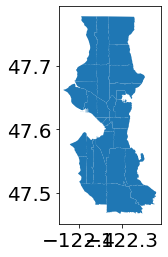

In [4]:
zips_sea.plot()

In [5]:
zips_sea.head()

,geometry,SHAPE_Area
ZIPCODE,,
98101,"POLYGON ((-122.32789 47.61571, -122.32790 47.6...",1.470012e+07
98102,"POLYGON ((-122.31234 47.64627, -122.31236 47.6...",4.322189e+07
98103,"POLYGON ((-122.32850 47.70136, -122.32850 47.7...",1.440083e+08
98104,"POLYGON ((-122.31699 47.60078, -122.31701 47.6...",2.108730e+07
98105,"MULTIPOLYGON (((-122.28680 47.65477, -122.2867...",9.703543e+07


## Census Boundary Download

In [6]:
census_bounds = get_census_bounds()

<AxesSubplot:>

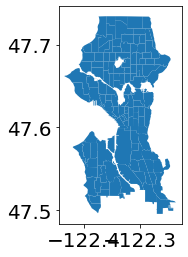

In [7]:
census_bounds.plot()

In [9]:
census_bounds.head()

,Tract,SHAPE_Area,geometry
0,25.0,1.059462e+07,"POLYGON ((-122.29602 47.69023, -122.29608 47.6..."
1,26.0,1.339838e+07,"POLYGON ((-122.30817 47.69031, -122.30947 47.6..."
2,56.0,3.212601e+07,"POLYGON ((-122.39300 47.63956, -122.39421 47.6..."
3,68.0,7.729233e+06,"POLYGON ((-122.35070 47.63994, -122.35130 47.6..."
4,60.0,1.413816e+07,"POLYGON ((-122.34279 47.64320, -122.34280 47.6..."


We also need to get the centroids of the census tract data for the population data set.

<ipython-input-10-4938a179621d>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  census_cent['geometry'] = census_cent['geometry'].centroid


<AxesSubplot:>

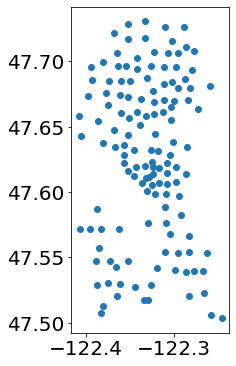

In [10]:
#Centroid points of census tracts
census_cent = census_bounds.copy()

census_cent['geometry'] = census_cent['geometry'].centroid
census_cent.plot(figsize=(15,6))

## Bike Rack data

In [11]:
# Loads bike rack data
racks_url = 'https://opendata.arcgis.com/datasets/f86c29ce743e47819e588c3d643ceb63_0.geojson'
r = gpd.read_file(racks_url)

In [28]:
# Creates a dataframe "racks" of bike rack locations and years installed
racks = r[['INSTALL_DATE', 'RACK_CAPACITY', 'geometry']]
racks = racks[racks.INSTALL_DATE.notnull()]
racks['Year'] = pd.DatetimeIndex(racks['INSTALL_DATE']).year
racks = racks.drop(columns='INSTALL_DATE')

In [29]:
racks_half_filtered = racks[racks['Year'] >= 2007]
racks_filtered = racks_half_filtered[racks_half_filtered['Year'] <= 2018]

In [30]:
zips_racks = gpd.sjoin(zips_sea, racks_filtered, op='contains')
zips_racks.reset_index(inplace=True)
zips_racks = zips_racks[['ZIPCODE', 'Year', 'RACK_CAPACITY']]
zips_racks.drop_duplicates(subset=['ZIPCODE', 'Year'], inplace=True)
zips_racks.sort_values(by=['ZIPCODE', 'Year'], inplace=True)

In [36]:
zips_racks.head()

,ZIPCODE,Year,RACK_CAPACITY
31,98101,2007,2
0,98101,2008,2
2,98101,2009,2
43,98101,2010,2
47,98101,2011,2


In [37]:
len(zips_racks)

243

## Bike Lanes

In [194]:
#Bike lanes and walkways
bike_lanes_url = 'https://gisdata.seattle.gov/server/rest/services/SDOT/SDOT_Bikes/MapServer/1/query?where=1%3D1&outFields=OBJECTID,STREET_NAME,LENGTH_MILES,SHAPE,DATE_COMPLETED,SHAPE_Length&outSR=4326&f=json'
bike_lanes = gpd.read_file(bike_lanes_url)

/home/mcanin/miniconda3/envs/green_env/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [196]:
lane_columns = ['LENGTH_MILES', 'DATE_COMPLETED', 'geometry']
bike_lane = bike_lanes[lane_columns]
bike_lane['DATE_COMPLETED'] = pd.to_datetime(bike_lane['DATE_COMPLETED'], unit='ms')
bike_lane['Year'] = pd.DatetimeIndex(bike_lane['DATE_COMPLETED']).year
bike_lane = bike_lane.drop(columns='DATE_COMPLETED')
bike_lane['Year'] = bike_lane['Year'].fillna(0)

In [197]:
# Zip codes and bike lanes from 2007 onward
bike_lane_now = bike_lane[bike_lane['Year'] >= 2007]
zips_lane = gpd.sjoin(zips_sea, bike_lane_now, op='intersects')
zips_lane['Year'] = zips_lane['Year'].astype(int)
zips_lane.reset_index(inplace=True)
zips_lane.drop_duplicates(subset=['ZIPCODE', 'Year'], inplace=True)
zips_lane = zips_lane[['ZIPCODE', 'Year', 'LENGTH_MILES']]
zips_lane.sort_values(by=['ZIPCODE', 'Year'], inplace=True)

In [198]:
# Zip codes and bike lanes before 2007
bike_lane_baseline = bike_lane[bike_lane['Year'] < 2007]
zips_lane_base = gpd.sjoin(zips_sea, bike_lane_baseline, op='intersects')
zips_lane_base.reset_index(inplace=True)
zips_lane_base.drop_duplicates(subset=['ZIPCODE', 'Year'], inplace=True)
zips_lane_base = zips_lane_base.groupby(by='ZIPCODE').sum()
zips_lane_base.reset_index(inplace=True)
zips_lane_base = zips_lane_base[['ZIPCODE', 'Year', 'LENGTH_MILES']]

In [202]:
zips_lane['ZIPCODE'].head()

4     98101
2     98101
0     98101
9     98101
15    98102
Name: ZIPCODE, dtype: int64

In [207]:
zip_list = list(zips_lane_base.ZIPCODE.unique())
lst = [98101, 98102]

In [217]:
zips_lane_base.ZIPCODE.values[0]

98101

In [209]:
zips_lane.head()
lane_sum = pd.Series(dtype=float)

In [206]:
zips_lane[zips_lane.ZIPCODE==98101].iloc[0,-1]

0.05796134

In [218]:
for i in range(0,2):
    base_val = zips_lane[zips_lane_base.ZIPCODE == lst[i]].iloc[0,-1]
    print(base_val)
    
    #add = zips_lane[zips_lane.ZIPCODE==zipcode].iloc[0,-1] + zips_lane_base[zips_lane_base.ZIPCODE==zipcode].iloc[0,-1]
    zips_lane[zips_lane.ZIPCODE==zipcode].iloc[0,-1] = add
    print(zips_lane[zips_lane.ZIPCODE==zipcode].iloc[0,-1])

KeyError: 98101

In [ ]:
# Creates a dataframe "zipracks" of zip codes, years, and area density of bike racks (*10^6)
zipracks = zr.groupby(['Zipcode', 'Year']).size().reset_index()
zipracks.rename(columns={0: 'Num_racks'}, inplace=True)
zip_list = zipracks.Zipcode.unique()
for zipcode in zip_list:
    indices = zipracks[zipracks.Zipcode==zipcode].index
    zipracks.loc[indices, 'Num_racks'] = zipracks.loc[indices, 'Num_racks'].cumsum()
    area = ziptracts[ziptracts.Zipcode==zipcode]['Area (ft^2)?'].unique()
    zipracks.loc[indices, 'Num_racks'] = zipracks.loc[indices, 'Num_racks'] / area * 10**6
zipracks.rename(columns={'Num_racks': 'Density_racks'}, inplace=True)

In [124]:
zip_list

[98101,
 98103,
 98104,
 98105,
 98109,
 98118,
 98119,
 98121,
 98125,
 98133,
 98134,
 98199,
 98108,
 98136,
 98115,
 98116,
 98126,
 98106,
 98107,
 98117,
 98122,
 98144,
 98102,
 98195]

In [44]:

year_fill = [0] *len(zip_list)

In [31]:
zip_sum_list = []*len(zip_list)
for zipcode in zip_list:
    selection = zips_lane_base_diss.loc[zips_lane_base_diss['ZIPCODE'] == zipcode]
    zip_sum = selection['LENGTH_MILES'].sum()
    zip_sum_list.append(zip_sum)
zip_sum_list    

[0.12729949000000002,
 3.79676578,
 0.12240970000000001,
 1.62291752,
 0.8736424700000001,
 0.5728122600000001,
 1.7576620399999998,
 0.16140332000000002,
 2.34083653,
 0.94037638,
 2.08833848,
 1.8446894699999998,
 0.17016786,
 0.25657044,
 2.31539726,
 1.13196364,
 1.38798814,
 1.2581715,
 0.25387693,
 0.12615118,
 0.60992247,
 0.85187075,
 0.08255799999999999,
 0.01248003]

In [65]:
base_df = pd.DataFrame(list(zip(zip_list, year_fill, zip_sum_list)), index = range(len(zip_list)), columns = ['ZIPCODE', 'Year', 'Miles_Bike_Lanes'] )

In [66]:
base_df

,ZIPCODE,Year,Miles_Bike_Lanes
0,98101,0,0.127299
1,98103,0,3.796766
2,98104,0,0.122410
3,98105,0,1.622918
4,98109,0,0.873642
5,98118,0,0.572812
6,98119,0,1.757662
7,98121,0,0.161403
8,98125,0,2.340837
9,98133,0,0.940376


In [51]:
#selects only data points with years after 2007 to match traffic data
bike_half_filtered = bike_lane[bike_lane['Year'] >= 2007]

In [52]:
#selects only data points with years before 2018 to match traffic data
bike_filtered = bike_half_filtered[bike_half_filtered['Year'] <= 2018]

In [53]:
print(bike_filtered['Year'].unique())

[2012. 2007. 2015. 2009. 2017. 2014. 2008. 2018. 2011. 2013. 2016. 2010.]


In [54]:
# # Joins zip codes with bike racks
zips_bikelane = gpd.sjoin(zips_sea, bike_filtered, op='intersects')

In [55]:
zips_bikelane.reset_index(inplace=True)

In [56]:
zips_bikelane.head()

,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,LENGTH_MILES,Year
0,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,359,0.057961,2008.0
1,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,799,0.060972,2009.0
2,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,537,0.061002,2009.0
3,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,531,0.060967,2009.0
4,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,535,0.046915,2012.0


In [68]:
zips_lanes = zips_bikelane.dissolve(by=['Year', 'ZIPCODE'], aggfunc=sum)

In [69]:
zips_lanes.reset_index(inplace=True)

In [70]:
zips_lanes.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,LENGTH_MILES
0,2007.0,98103,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",360.00,1.152067e+09,4349,0.435469
1,2007.0,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",84.00,2.108730e+07,540,0.058115
2,2007.0,98105,"MULTIPOLYGON (((-122.32860 47.66653, -122.3286...",41.00,9.703543e+07,646,0.093853
3,2007.0,98106,"POLYGON ((-122.37057 47.56924, -122.37056 47.5...",798.14,1.037410e+09,4280,0.629000
4,2007.0,98107,"MULTIPOLYGON (((-122.40896 47.67540, -122.4072...",144.00,1.963532e+08,743,0.151018


In [71]:
len(zips_lanes)

141

In [72]:
zips_lanes_clean = zips_lanes[['Year', 'ZIPCODE', "LENGTH_MILES"]]

In [75]:
zips_lanes_clean = zips_lanes_clean.rename(columns = {'LENGTH_MILES' : 'Miles_Bike_Lanes'})

In [76]:
zips_lanes_clean

,Year,ZIPCODE,Miles_Bike_Lanes
0,2007.0,98103,0.435469
1,2007.0,98104,0.058115
2,2007.0,98105,0.093853
3,2007.0,98106,0.629000
4,2007.0,98107,0.151018
...,...,...,...
136,2017.0,98199,0.599701
137,2018.0,98101,0.161397
138,2018.0,98108,0.385548
139,2018.0,98118,0.293533


In [77]:
zips_lanes_clean = base_df.append(zips_lanes_clean)

In [78]:
zips_lanes_clean.head()

,ZIPCODE,Year,Miles_Bike_Lanes
0,98101,0.0,0.127299
1,98103,0.0,3.796766
2,98104,0.0,0.122410
3,98105,0.0,1.622918
4,98109,0.0,0.873642


## Walkways

Note: the walkways data is from the same dataset as the bike lanes, so we just need to select the proper category.

In [144]:
walks = bike_filtered[bike_filtered['SEGMENT_TY']==7]

In [145]:
walks.head()

,SEGMENT_TY,SNDSEG_UPD,SHAPE_Leng,geometry,Year
761,7,2007-02-01,24.912878,"LINESTRING (-122.34617 47.61009, -122.34610 47...",2007
762,7,2007-01-31,258.640746,"LINESTRING (-122.30014 47.58947, -122.30002 47...",2007
763,7,2007-01-30,131.107978,"LINESTRING (-122.27248 47.55940, -122.27195 47...",2007
3378,7,2007-04-23,326.429462,"LINESTRING (-122.34079 47.60882, -122.34149 47...",2007
5341,7,2007-04-23,147.944588,"LINESTRING (-122.34149 47.60958, -122.34175 47...",2007


In [146]:
# # Joins zip codes with bike racks
zips_walks = gpd.sjoin(zips_sea, walks, op='intersects')

In [147]:
zips_walks.reset_index(inplace=True)

In [148]:
zips_walks.head()

,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,SEGMENT_TY,SNDSEG_UPD,SHAPE_Leng,Year
0,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,26217,7,2007-01-30,170.841839,2007
1,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,33047,7,2018-10-10,56.423606,2018
2,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,11592,7,2007-04-23,405.286834,2007
3,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,3378,7,2007-04-23,326.429462,2007
4,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,9204,7,2007-02-02,26.665316,2007


In [149]:
zips_walks['Year'].unique()

array([2007, 2018, 2011, 2017, 2015, 2014, 2016, 2013, 2009, 2010, 2012,
       2008])

In [150]:
zips_walkways = zips_walks.dissolve(by=['Year', 'ZIPCODE'], aggfunc=sum)

In [151]:
zips_walkways.reset_index(inplace=True)

In [152]:
zips_walkways.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,SEGMENT_TY,SHAPE_Leng
0,2007,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",444.12,8.820074e+07,72379,42,1509.392162
1,2007,98109,"POLYGON ((-122.35819 47.64769, -122.35810 47.6...",222.03,1.990673e+08,31855,21,674.574261
2,2007,98112,"MULTIPOLYGON (((-122.31863 47.63049, -122.3186...",65.00,8.818645e+07,13307,7,167.882583
3,2007,98118,"MULTIPOLYGON (((-122.29240 47.53008, -122.2919...",117.00,1.707186e+08,763,7,131.107978
4,2007,98121,"POLYGON ((-122.36110 47.61854, -122.36095 47.6...",324.00,4.900877e+07,38876,28,556.487265


In [153]:
len(zips_walkways)

105

In [154]:
zips_walkways_clean = zips_walkways[['Year', 'ZIPCODE', "SHAPE_Leng"]]

In [155]:
zips_walkways_clean = zips_walkways_clean.rename(columns = {'SHAPE_Leng': "Walkway_Length"})

## Populations

The population data is sorted by census tract, so to avoid double counting populations we will do a spatial join by centroids instead of across the two polygons.

In [59]:
pop_url_2010 = 'https://gisrevprxy.seattle.gov/arcgis/rest/services/CENSUS_EXT/CENSUS_2010_BASICS/MapServer/15/query?where=1%3D1&outFields=SHAPE,GEOID10,NAME10,ACRES_TOTAL,Total_Population,OBJECTID&outSR=4326&f=json'

In [60]:
pop_2010 = gpd.read_file(pop_url_2010)
pop_2010['geometry'] = census_cent['geometry']
pop_2010.head()

,GEOID10,NAME10,ACRES_TOTAL,Total_Population,OBJECTID,geometry
0,53033002500,25,243.219083,2802.0,1,POINT (-122.30228 47.68390)
1,53033002600,26,307.584420,4660.0,2,POINT (-122.31193 47.68275)
2,53033005600,56,737.511727,6382.0,3,POINT (-122.40574 47.64278)
3,53033006800,68,177.438771,2834.0,4,POINT (-122.35646 47.63603)
4,53033006000,60,324.567432,5150.0,5,POINT (-122.35286 47.64393)


<AxesSubplot:>

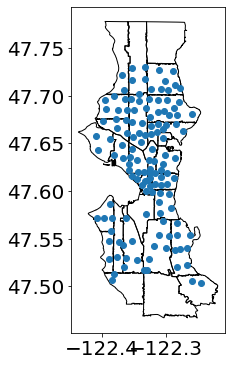

In [61]:
fig, ax = plt.subplots(figsize=(15,6))
zips.plot(ax=ax, facecolor='none',edgecolor='k')
pop_2010.plot(ax=ax)

<AxesSubplot:>

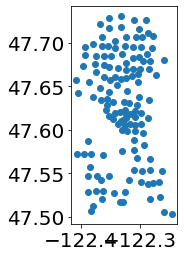

In [62]:
pop_2010.plot()

In [63]:
pop_2010.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [64]:
pop_zips = gpd.sjoin(zips_sea, pop_2010, op='contains')

In [65]:
pop_zips.head()

,geometry,NAME10_left,SHAPE_Area_left,index_right,GEOID10,NAME10_right,ACRES_TOTAL,Total_Population,OBJECTID
ZIPCODE,,,,,,,,,
98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,65,53033008100,81,206.340307,4070.0,66
98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,66,53033008200,82,90.611670,3280.0,67
98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,67,53033008300,83,58.672725,2505.0,68
98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",74.02,4.322189e+07,75,53033007401,74.01,64.092745,4115.0,76
98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",74.02,4.322189e+07,82,53033006100,61,276.424774,4796.0,83


<AxesSubplot:>

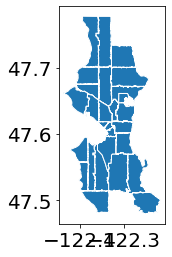

In [66]:
pop_zips.plot(edgecolor = 'white')

In [67]:
pop_zips.reset_index(inplace=True)

In [68]:
pop_zips = pop_zips[['ZIPCODE','geometry', 'Total_Population']]

In [69]:
pop_zips.head()

,ZIPCODE,geometry,Total_Population
0,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",4070.0
1,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",3280.0
2,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",2505.0
3,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",4115.0
4,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",4796.0


In [70]:
pop_zips_diss = pop_zips.dissolve(by='ZIPCODE', aggfunc='sum')

In [71]:
pop_zips_diss.reset_index(inplace=True)

In [72]:
pop_zips_diss.head()

,ZIPCODE,geometry,Total_Population
0,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",9855.0
1,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",12451.0
2,98103,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",43659.0
3,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",9674.0
4,98105,"MULTIPOLYGON (((-122.32859 47.66649, -122.3286...",44553.0


In [73]:
pop_zips_diss_clean = pop_zips_diss[['ZIPCODE', 'Total_Population']]

In [74]:
total_pop = pop_zips_diss_clean['Total_Population'].sum()
total_pop

608660.0

In [75]:
pop_zips_diss_clean['Pop_fraction'] = pop_zips_diss_clean['Total_Population']/total_pop
pop_zips_diss_clean.head()

,ZIPCODE,Total_Population,Pop_fraction
0,98101,9855.0,0.016191
1,98102,12451.0,0.020456
2,98103,43659.0,0.071730
3,98104,9674.0,0.015894
4,98105,44553.0,0.073199


In [76]:
years = list(range(2007, 2019))
years

[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

In [77]:
populations = [585436, 591870, 598539, 608660, 622694, 635928, 653588, 670109, 687386, 709631, 728661, 742235]

In [78]:
pop_by_year = dict(zip(years, populations))
pop_by_year

{2007: 585436,
 2008: 591870,
 2009: 598539,
 2010: 608660,
 2011: 622694,
 2012: 635928,
 2013: 653588,
 2014: 670109,
 2015: 687386,
 2016: 709631,
 2017: 728661,
 2018: 742235}

In [79]:
def est_zip_pop(year, pop_zips_diss_clean, pop_by_year):
    pop_frac = pop_zips_diss_clean['Pop_fraction'].values
    year_pop = pop_by_year.get(year)
    pop_zip_year = pop_zips_diss_clean.copy()
    pop_zip_year['Total_Population'] = pop_frac*year_pop
    return pop_zip_year

In [80]:
pop_zip_2007 = est_zip_pop(2007, pop_zips_diss_clean, pop_by_year)
pop_zip_2007.head()

,ZIPCODE,Total_Population,Pop_fraction
0,98101,9478.973121,0.016191
1,98102,11975.920277,0.020456
2,98103,41993.149417,0.071730
3,98104,9304.879348,0.015894
4,98105,42853.037998,0.073199


In [81]:
total_pop_2007 = pop_zip_2007['Total_Population'].sum()
total_pop_2007

585435.9999999999

In [82]:
pop_zips_years = gpd.GeoDataFrame()
for year in years:
    pop_zip_year = est_zip_pop(year, pop_zips_diss_clean, pop_by_year)
    pop_zip_year['Year'] = year
    pop_zips_years = pop_zips_years.append(pop_zip_year)


In [83]:
pop_zips_years

,ZIPCODE,Total_Population,Pop_fraction,Year
0,98101,9478.973121,0.016191,2007
1,98102,11975.920277,0.020456,2007
2,98103,41993.149417,0.071730,2007
3,98104,9304.879348,0.015894,2007
4,98105,42853.037998,0.073199,2007
...,...,...,...,...
23,98146,7353.328706,0.009907,2018
24,98177,9771.512922,0.013165,2018
25,98178,8797.166382,0.011852,2018
26,98195,6958.224477,0.009375,2018


In [84]:
pop_zips_years.tail()

,ZIPCODE,Total_Population,Pop_fraction,Year
23,98146,7353.328706,0.009907,2018
24,98177,9771.512922,0.013165,2018
25,98178,8797.166382,0.011852,2018
26,98195,6958.224477,0.009375,2018
27,98199,20884.429090,0.028137,2018


In [85]:
len(pop_zips_years)

336

In [86]:
pop_zips_years = pop_zips_years[['Year', 'ZIPCODE', 'Total_Population', 'Pop_fraction']]

## Getting traffic data for 2017

In [87]:
gdf_17 = get_gdf(17)

In [88]:
gdf_17.head()

,YEAR,AAWDT,GEOBASID,STNAME,SHAPE_Length,geometry
0,2017,10835,375,15TH AVE S,898.373909,"MULTILINESTRING ((-122.31343 47.56987, -122.31..."
1,2017,4170,1525,FREMONT AVE N,1059.740443,"MULTILINESTRING ((-122.35003 47.66214, -122.35..."
2,2017,9513,1861,N 115TH ST,2648.272605,"MULTILINESTRING ((-122.34212 47.71231, -122.34..."
3,2017,9620,1219,"W GALER ST,MAGNOLIA BLVD W",2097.673439,"MULTILINESTRING ((-122.39301 47.63230, -122.39..."
4,2017,6736,1173,19TH AVE E,2321.878141,"MULTILINESTRING ((-122.30732 47.62207, -122.30..."


In [125]:
tot_traffic_2017_sum = gdf_17['AAWDT'].sum()

In [126]:
tot_traffic_2017_sum

22771194

In [129]:
tot_traffic_2017_dict = {'Year': [2017], 'Traffic Count': [tot_traffic_2017_sum]}

In [130]:
tot_traffic_2017 = pd.DataFrame(tot_traffic_2017_dict)

In [131]:
tot_traffic_2017

,Year,Traffic Count
0,2017,22771194


In [89]:
def traffic_in_zip(year):
    '''Function to generate distributions of traffic flow by year in each zip
    '''
    gdf_test = get_gdf(7)

    midpoints = gdf_test.copy()
    midpoints['MIDPOINT'] = gdf_test['geometry'].interpolate(0.5, normalized = True)
    midpoint_columns = ['YEAR', 'AAWDT', 'MIDPOINT']
    midpoint_cleaned = midpoints.loc[:,midpoint_columns]
    midpoint_cleaned['geometry'] = midpoint_cleaned['MIDPOINT']
    
    zip_mids = gpd.sjoin(zips,midpoint_cleaned,op='contains')
    zip_mids = zip_mids.dissolve(by='ZIPCODE',aggfunc=sum)
    zip_mids_cleaned = zip_mids.loc[:,['AAWDT']]
    
    return zip_mids_cleaned

In [90]:
zips_traffic_2017 = traffic_in_zip(2017)

<ipython-input-89-ca455966e74d>:7: UserWarning: Geometry is in a geographic CRS. Results from 'interpolate' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  midpoints['MIDPOINT'] = gdf_test['geometry'].interpolate(0.5, normalized = True)


In [91]:
zips_traffic_2017.head()

,AAWDT
ZIPCODE,
98101,264800
98102,64200
98103,331360
98104,305400
98105,176095


# Merging all features into one dataset for model

In [257]:
a = pd.merge(pop_zips_years, zips_racks_clean, how='left', on= ['Year', 'ZIPCODE'])

In [258]:
a.head()

,Year,ZIPCODE,Total_Population,Pop_fraction,RACK_CAPACITY
0,2007,98101,9478.973121,0.016191,16.0
1,2007,98102,11975.920277,0.020456,4.0
2,2007,98103,41993.149417,0.071730,20.0
3,2007,98104,9304.879348,0.015894,10.0
4,2007,98105,42853.037998,0.073199,34.0


In [259]:
b = pd.merge(a, zips_lanes_clean, how='left', on= ['Year', 'ZIPCODE'])

In [260]:
all_data = pd.merge(b, zips_walkways_clean, how='left', on =['Year', 'ZIPCODE'])

In [261]:
len(all_data)

336

In [262]:
all_data.head()

,Year,ZIPCODE,Total_Population,Pop_fraction,RACK_CAPACITY,LENGTH_MILES,Walkway_Length
0,2007,98101,9478.973121,0.016191,16.0,NaN,1509.392162
1,2007,98102,11975.920277,0.020456,4.0,NaN,NaN
2,2007,98103,41993.149417,0.071730,20.0,0.435469,NaN
3,2007,98104,9304.879348,0.015894,10.0,0.058115,NaN
4,2007,98105,42853.037998,0.073199,34.0,0.093853,NaN


In [263]:
all_data_2017 = all_data.loc[all_data['Year'] == 2017]

In [101]:
real_all_data_2017 = pd.merge(all_data_2017, zips_traffic_2017, how='left', on='ZIPCODE')

In [103]:
real_all_data_2017.tail()

,Year,ZIPCODE,Total_Population,Pop_fraction,RACK_CAPACITY,Lane_Length,Walkway_Length,AAWDT
23,2017,98146,7218.850968,0.009907,NaN,NaN,NaN,9600
24,2017,98177,9592.811410,0.013165,NaN,NaN,NaN,8300
25,2017,98178,8636.283728,0.011852,NaN,NaN,NaN,18700
26,2017,98195,6830.972408,0.009375,NaN,NaN,NaN,119600
27,2017,98199,20502.494473,0.028137,NaN,NaN,NaN,71500


In [106]:
complete_data_2017 = all_data['ZIPCODE'].any(98112, 98118, 98126, 98144)

NotImplementedError: Option bool_only is not implemented with option level.

In [227]:
len(all_data_2007)

28

In [264]:
for year in years:
    all_data_year = all_data.loc[all_data['Year'] == year]
    print(year, ':', all_data_year.isnull().sum())

2007 : Year                 0
ZIPCODE              0
Total_Population     0
Pop_fraction         0
RACK_CAPACITY        9
LENGTH_MILES        16
Walkway_Length      20
dtype: int64
2008 : Year                 0
ZIPCODE              0
Total_Population     0
Pop_fraction         0
RACK_CAPACITY        6
LENGTH_MILES         7
Walkway_Length      26
dtype: int64
2009 : Year                 0
ZIPCODE              0
Total_Population     0
Pop_fraction         0
RACK_CAPACITY        5
LENGTH_MILES         6
Walkway_Length      26
dtype: int64
2010 : Year                 0
ZIPCODE              0
Total_Population     0
Pop_fraction         0
RACK_CAPACITY       11
LENGTH_MILES        12
Walkway_Length      27
dtype: int64
2011 : Year                 0
ZIPCODE              0
Total_Population     0
Pop_fraction         0
RACK_CAPACITY       14
LENGTH_MILES        15
Walkway_Length       9
dtype: int64
2012 : Year                 0
ZIPCODE              0
Total_Population     0
Pop_fraction       

Years with at least one instance of all 4 features: 2008, 2014 - 2018

For 2008:
* lanes has data for 98109 and 98126
* walks has 98136

For 2014: 
* lanes has data for 98105, 98112, 98126, 98144
* walks has 98117

For 2015: 
* lanes has data for 98103, 98105, 98106, 98108, 98109, 98112, 98116, 98117, 98119, 98126, 98144, 98146, 98145, 98199
* walks has 98106 and 98121
* __98106 is a match__

For 2016: 
* lanes has data for 98103, 98105, 98112, 98115
* walks has 98119, 98121, and and 98199

For 2017: 
* lanes has data for 98104, 98105, 98106, 98107, 98108, 98112, 98115, 98116, 98118, 98119, 98121, 98122, 98125, 98126, 98136, 98144
* walks has 98112, 98118, 98126, and 98144
* __98112, 98118, 98126, and 98144 is a match__

For 2018: 
* lanes has data for 98101, 98118, 98122, and 98126
* walks has 98104, 98105, 98107, 98116, and 98126
* __98126 is a match__

In [255]:
zips_lanes_2018 = zips_lanes_clean.loc[zips_lanes_clean['Year'] == 2018]

In [256]:
zips_lanes_2018

,Year,ZIPCODE,Lane_Length
69,2018,98101,348.181761
70,2018,98118,269.759130
71,2018,98122,134.256722
72,2018,98126,103.611745


In [257]:
zips_walks_2018 = zips_walkways_clean.loc[zips_walkways_clean['Year'] == 2018]

In [258]:
zips_walks_2018

,Year,ZIPCODE,Walkway_Length
11,2018,98104,612.361474
12,2018,98105,909.234692
13,2018,98107,195.281209
14,2018,98116,1319.979585
15,2018,98126,1422.466556


In [261]:
zips_racks_2017 = zips_racks_clean.loc[zips_racks_clean['Year'] == 2017]
zips_racks_2017

,Year,ZIPCODE,RACK_CAPACITY
205,2017,98101,6
206,2017,98102,22
207,2017,98103,20
208,2017,98104,102
209,2017,98106,24
210,2017,98107,28
211,2017,98108,6
212,2017,98109,16
213,2017,98112,2
214,2017,98115,2


In [259]:
zips_racks_2010 = zips_racks.loc[zips_racks['Year'] == 2010]

In [124]:
zips_racks_2010.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,RACK_CAPACITY
65,2010,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",148.04,2.940025e+07,2082,4
66,2010,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",296.08,1.728875e+08,9258,8
67,2010,98103,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",315.00,1.008058e+09,14057,32
68,2010,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",84.00,2.108730e+07,30,14
69,2010,98105,"MULTIPOLYGON (((-122.32859 47.66646, -122.3285...",205.00,4.851772e+08,9872,22


In [125]:
zips_lanes_2010 = zips_lanes.loc[zips_lanes['Year'] == 2010]
zips_lanes_2010.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,SEGMENT_TY,SHAPE_Leng
7,2010,98109,"POLYGON ((-122.35819 47.64769, -122.35810 47.6...",74.01,6.635577e+07,18952,6,157.179735


In [126]:
zips_walkways_2010 = zips_walkways.loc[zips_walkways['Year'] == 2010]
zips_walkways_2010.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,SEGMENT_TY,SHAPE_Leng


In [127]:
pops_zips_years_2010 = pop_zips_years.loc[pop_zips_years['Year'] == 2010]
pops_zips_years_2010.head()

,Year,ZIPCODE,Total_Population,Pop_fraction,geometry
0,2010,98101,9855.0,0.016191,"POLYGON ((-122.34598 47.60892, -122.34490 47.6..."
1,2010,98102,12451.0,0.020456,"POLYGON ((-122.33574 47.64203, -122.33108 47.6..."
2,2010,98103,43659.0,0.071730,"POLYGON ((-122.35808 47.69966, -122.35741 47.6..."
3,2010,98104,9674.0,0.015894,"POLYGON ((-122.34105 47.59627, -122.34031 47.5..."
4,2010,98105,44553.0,0.073199,"MULTIPOLYGON (((-122.32859 47.66649, -122.3286..."


In [140]:
len(pops_zips_years_2010)

28

In [130]:
zips_racks_2010_pd = pd.DataFrame(zips_racks_2010)

In [131]:
pops_zips_years_2010_pd = pd.DataFrame(pops_zips_years_2010)

In [150]:
test = pd.merge(pops_zips_years_2010_pd, zips_racks_2010,  how ='left', on='ZIPCODE')

In [151]:
len(test)

28

In [152]:
test2 = pd.merge(test, zips_lanes_2010, how = 'left', on = 'ZIPCODE')

In [153]:
len(test2)

28

In [156]:
test2.head(10)

,Year_x,ZIPCODE,Total_Population,Pop_fraction,geometry_x,Year_y,geometry_y,NAME10_x,SHAPE_Area_left_x,index_right_x,RACK_CAPACITY,Year,geometry,NAME10_y,SHAPE_Area_left_y,index_right_y,SEGMENT_TY,SHAPE_Leng
0,2010,98101,9855.0,0.016191,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",2010.0,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",148.04,2.940025e+07,2082.0,4.0,NaN,None,NaN,NaN,NaN,NaN,NaN
1,2010,98102,12451.0,0.020456,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",2010.0,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",296.08,1.728875e+08,9258.0,8.0,NaN,None,NaN,NaN,NaN,NaN,NaN
2,2010,98103,43659.0,0.071730,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",2010.0,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",315.00,1.008058e+09,14057.0,32.0,NaN,None,NaN,NaN,NaN,NaN,NaN
3,2010,98104,9674.0,0.015894,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",2010.0,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",84.00,2.108730e+07,30.0,14.0,NaN,None,NaN,NaN,NaN,NaN,NaN
4,2010,98105,44553.0,0.073199,"MULTIPOLYGON (((-122.32859 47.66649, -122.3286...",2010.0,"MULTIPOLYGON (((-122.32859 47.66646, -122.3285...",205.00,4.851772e+08,9872.0,22.0,NaN,None,NaN,NaN,NaN,NaN,NaN
5,2010,98106,23568.0,0.038721,"POLYGON ((-122.37057 47.56924, -122.37056 47.5...",2010.0,"POLYGON ((-122.37057 47.56924, -122.37056 47.5...",114.02,1.482014e+08,1142.0,2.0,NaN,None,NaN,NaN,NaN,NaN,NaN
6,2010,98107,22263.0,0.036577,"MULTIPOLYGON (((-122.40896 47.67540, -122.4072...",2010.0,"MULTIPOLYGON (((-122.40896 47.67540, -122.4072...",96.00,1.309021e+08,3303.0,16.0,NaN,None,NaN,NaN,NaN,NaN,NaN
7,2010,98108,22590.0,0.037114,"POLYGON ((-122.33799 47.53397, -122.33787 47.5...",2010.0,"POLYGON ((-122.33799 47.53397, -122.33787 47.5...",465.00,1.075290e+09,10624.0,10.0,NaN,None,NaN,NaN,NaN,NaN,NaN
8,2010,98109,31473.0,0.051709,"POLYGON ((-122.35819 47.64769, -122.35810 47.6...",NaN,None,NaN,NaN,NaN,NaN,2010.0,"POLYGON ((-122.35819 47.64769, -122.35810 47.6...",74.01,6.635577e+07,18952.0,6.0,157.179735
9,2010,98112,24148.0,0.039674,"MULTIPOLYGON (((-122.31863 47.63041, -122.3186...",2010.0,"MULTIPOLYGON (((-122.31863 47.63049, -122.3186...",130.00,1.763729e+08,713.0,4.0,NaN,None,NaN,NaN,NaN,NaN,NaN
